## Conformal prediction for M2 Money supply (monthly, unadjusted)

## 0. Imports

In [77]:
pip install statsforecast==2.0.1

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive, AutoETS, AutoARIMA, ARIMA, Naive, Theta
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, smape, mase
from functools import partial
from statsmodels.stats.diagnostic import acorr_ljungbox
from matplotlib.dates import DateFormatter

## 1. Exploratory data analysis

In [79]:
df = pd.read_csv('/content/FRED_M2_M_UNADJUSTED_2025-05-11 (1).csv')

In [80]:
df.head()

,realtime_start,realtime_end,date,value
0,2025-05-11,2025-05-11,1959-01-01,289.8
1,2025-05-11,2025-05-11,1959-02-01,287.7
2,2025-05-11,2025-05-11,1959-03-01,287.9
3,2025-05-11,2025-05-11,1959-04-01,290.2
4,2025-05-11,2025-05-11,1959-05-01,290.2


In [81]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['realtime_start'] = pd.to_datetime(df['realtime_start'], infer_datetime_format=True)
df['realtime_end'] = pd.to_datetime(df['realtime_end'], infer_datetime_format=True)

<ipython-input-81-ba3ebf1d4b67>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
<ipython-input-81-ba3ebf1d4b67>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['realtime_start'] = pd.to_datetime(df['realtime_start'], infer_datetime_format=True)
<ipython-input-81-ba3ebf1d4b67>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-dateti

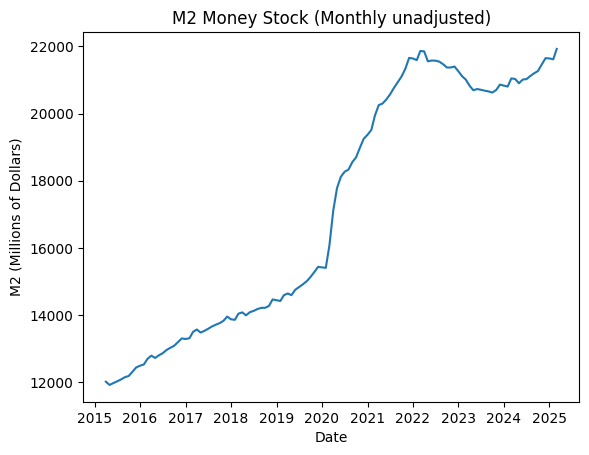

In [82]:
plot_df = df.tail(120)
plt.plot(plot_df['date'], plot_df['value'])
plt.xlabel('Date')
plt.ylabel('M2 (Millions of Dollars)')
plt.title('M2 Money Stock (Monthly unadjusted)')
plt.show()

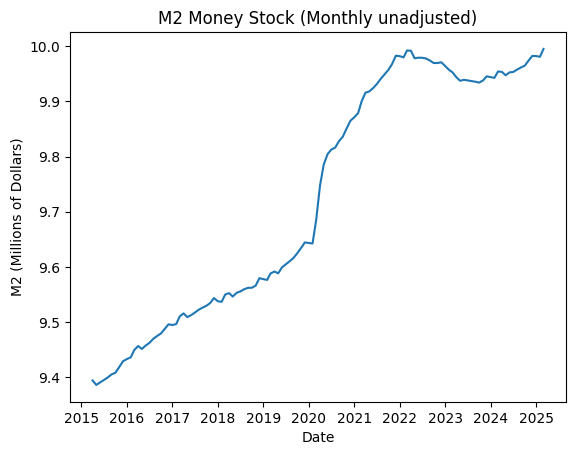

In [83]:
plt.plot(plot_df['date'], np.log(plot_df['value']))
plt.xlabel('Date')
plt.ylabel('M2 (Millions of Dollars)')
plt.title('M2 Money Stock (Monthly unadjusted)')
plt.show()

#### Seasonal Trend Decomposition

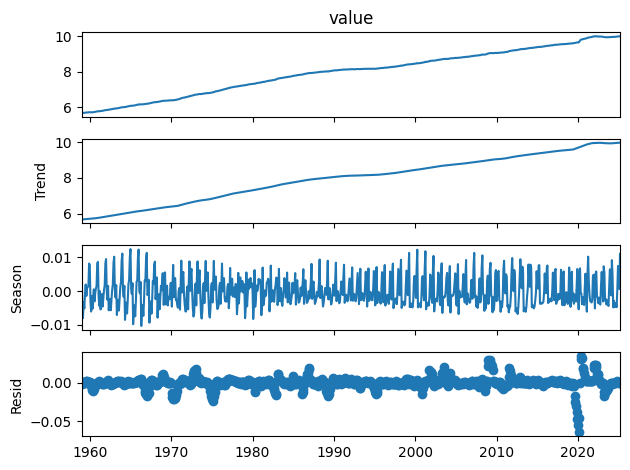

In [84]:
stl = STL(np.log(df.set_index('date')['value']), period=12, robust=True).fit()
stl.plot()
plt.show()

In [85]:
seasonal_strength = 1 - (stl.resid.var() / (stl.seasonal + stl.resid).var())
print(f"Seasonal strength (log scale): {seasonal_strength:.3f}")

Seasonal strength (log scale): 0.198


##### Interpretation

*   Log-scale trend is smooth and monotonically increasing
*   Weak 12-month seasonality
*   Mostly homoskedastic, large outliers only during year 2020



#### Stationarity test


In [86]:
df['value_log'] = np.log(df['value'])
adf_stat, pval, *_ = adfuller(df['value_log'])
print(f"ADF on log-level p = {pval:.4f}")

ADF on log-level p = 0.4625


In [87]:
df['value_log_diff'] = df['value_log'].diff()    # 1st diff
adf_stat, pval, *_ = adfuller(df['value_log_diff'].dropna())
print(f"ADF on log-diff  p = {pval:.4f}")

ADF on log-diff  p = 0.0000


## 2. Preprocessing


In [88]:
df["unique_id"] = "M2NS"

df_mod = (
    df[["unique_id", "date", "value_log_diff"]]
      .rename(columns={"value_log_diff": "y", "date": "ds"})
      .dropna(subset=["y"])
)

df_mod["period"] = df_mod["ds"].dt.to_period("M")
df_mod["ds"] = df_mod["period"].dt.to_timestamp(how="end")

In [89]:
train_end = "2019-12"
cal_end   = "2022-12"

train_df = df_mod[df_mod["period"] <= train_end].copy()
cal_df   = df_mod[(df_mod["period"] > train_end) & (df_mod["period"] <= cal_end)].copy()
cal_df   = cal_df.iloc[0: cal_df.shape[0]]
test_df  = df_mod[df_mod["period"] > cal_end].copy()

print("Split summary (rows):")
print(f"  train : {train_df.shape[0]}  | {train_df['ds'].min().date()} → {train_df['ds'].max().date()}")
print(f"  calib : {cal_df.shape[0]}  | {cal_df['ds'].min().date()} → {cal_df['ds'].max().date()}")
print(f"  test  : {test_df.shape[0]}  | {test_df['ds'].min().date()} → {test_df['ds'].max().date()}")

Split summary (rows):
  train : 731  | 1959-02-28 → 2019-12-31
  calib : 36  | 2020-01-31 → 2022-12-31
  test  : 27  | 2023-01-31 → 2025-03-31


In [90]:
train_y = train_df["y"].values
cal_y   = cal_df["y"].reset_index(drop=True)
cal_idx = cal_df["period"].values

test_y  = test_df["y"].reset_index(drop=True)
test_idx = test_df["period"].values

## 3. Model specification & fitting


In [134]:
models = [
    Naive(),
    SeasonalNaive(season_length=12),
    #AutoARIMA(season_length=12, d=0, D=0, stepwise=True, max_p=5, max_q=5),
    #AutoETS(season_length=12, model="AAN"),
    ARIMA(order=(2, 0, 1), seasonal_order=(0, 1, 0), season_length=12, alias="ARIMA(2,0,1)(0,1,0)"),
    ARIMA(order=(2, 0, 1), seasonal_order=(1, 1, 0), season_length=12, alias="ARIMA(2,0,1)(1,1,0)"),
    ARIMA(order=(2, 0, 1), seasonal_order=(0, 1, 1), season_length=12, alias="ARIMA(2,0,1)(0,1,1)"),
    ARIMA(order=(2, 0, 1),seasonal_order=(2,1,0), season_length=12, alias="ARIMA(2,0,1)(2,1,1)"),
    Theta(),
]

sf_train = train_df[["unique_id", "ds", "y"]].copy()

sf = StatsForecast(models=models, freq="M", n_jobs=-1)
_ = sf.fit(sf_train)

In [135]:
cal_h  = len(cal_df)
test_h = len(test_df)

cal_fc  = sf.predict(h=cal_h, level=[])
cal_fc.index = cal_idx
full_fc = sf.predict(h=cal_h + test_h, level=[])
full_fc.index = np.concatenate([cal_idx, test_idx])
test_fc = full_fc.loc[test_idx]
model_cols = [c for c in cal_fc.columns if c not in {"unique_id", "ds"}]

/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


## 4. Conformal prediction intervals definition

In [136]:
alpha_levels = {0.10: "_90", 0.05: "_95"}

def conformal_interval(point: np.ndarray, residuals: np.ndarray, alpha: float):
    q_hat = np.quantile(np.abs(residuals), 1 - alpha)
    return point - q_hat, point + q_hat

results = {}
for mdl in model_cols:
    resid = cal_y.values - cal_fc[mdl].values
    lo_dict, hi_dict = {}, {}
    for alpha, suff in alpha_levels.items():
        lo, hi = conformal_interval(test_fc[mdl].values, resid, alpha)
        lo_dict[suff], hi_dict[suff] = lo, hi
    results[mdl] = {"point": test_fc[mdl].values, "lo": lo_dict, "hi": hi_dict, "resid": resid}

## 5. Accuracy & calibration

In [137]:

def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(200 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

def mase(insample: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray, m: int = 1) -> float:
    scale = np.mean(np.abs(insample[m:] - insample[:-m]))
    return np.mean(np.abs(y_true - y_pred)) / scale

metrics = []
for mdl, d in results.items():
    # ensure pure numpy arrays (Polars Series would break numpy ops / round)
    point = np.asarray(d["point"], dtype=float)
    y_true = np.asarray(test_y.values, dtype=float)
    row = {
        "model": mdl,
        "sMAPE": round(smape(y_true, point), 3),
        "MASE":  round(mase(train_y.astype(float), y_true, point, m=1), 3),
    }
    for alpha, suff in alpha_levels.items():
        lo = np.asarray(d["lo"][suff], dtype=float)
        hi = np.asarray(d["hi"][suff], dtype=float)
        coverage  = float(np.mean((y_true >= lo) & (y_true <= hi)))
        avg_width = float(np.mean(hi - lo))
        row[f"cov{suff}"] = round(coverage, 3)
        row[f"wid{suff}"] = round(avg_width, 4)
    metrics.append(row)

metrics_df = pd.DataFrame(metrics).set_index("model")
print("=== Accuracy & calibration summary ===")
print(metrics_df)
metrics_df.to_csv("metrics.csv")


=== Accuracy & calibration summary ===
                       sMAPE   MASE  cov_90  wid_90  cov_95  wid_95
model                                                              
Naive                142.175  1.485   1.000  0.0381     1.0  0.0585
SeasonalNaive         97.701  0.710   0.963  0.0253     1.0  0.0665
ARIMA(2,0,1)(0,1,0)   98.877  0.722   0.963  0.0252     1.0  0.0672
ARIMA(2,0,1)(1,1,0)   95.193  0.657   0.926  0.0232     1.0  0.0668
ARIMA(2,0,1)(0,1,1)  105.381  0.642   0.926  0.0231     1.0  0.0661
ARIMA(2,0,1)(2,1,1)   96.873  0.626   0.926  0.0232     1.0  0.0658
Theta                137.345  1.012   1.000  0.0348     1.0  0.0670


## 6. Model evaluation & diagnostics

Generating diagnostic plots …


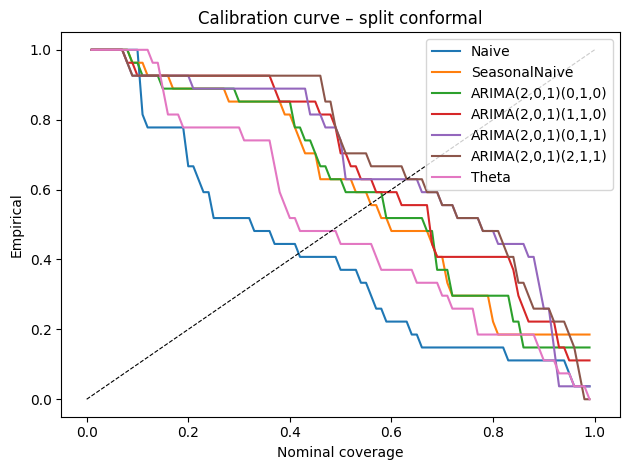

In [138]:
print("Generating diagnostic plots …")
levels = np.linspace(0.01, 0.99, 99)

# 7.1 Calibration curve ----------------------------------------------------
fig, ax = plt.subplots()
for mdl, d in results.items():
    resid = d["resid"]
    emp_cov = []
    for lv in levels:
        q_hat = np.quantile(np.abs(resid), 1 - lv)
        lo = d["point"] - q_hat
        hi = d["point"] + q_hat
        emp_cov.append(np.mean((test_y.values >= lo) & (test_y.values <= hi)))
    ax.plot(levels, emp_cov, label=mdl)
ax.plot([0, 1], [0, 1], "k--", lw=0.8)
ax.set(xlabel="Nominal coverage", ylabel="Empirical", title="Calibration curve – split conformal")
ax.legend()
fig.tight_layout()
plt.show()

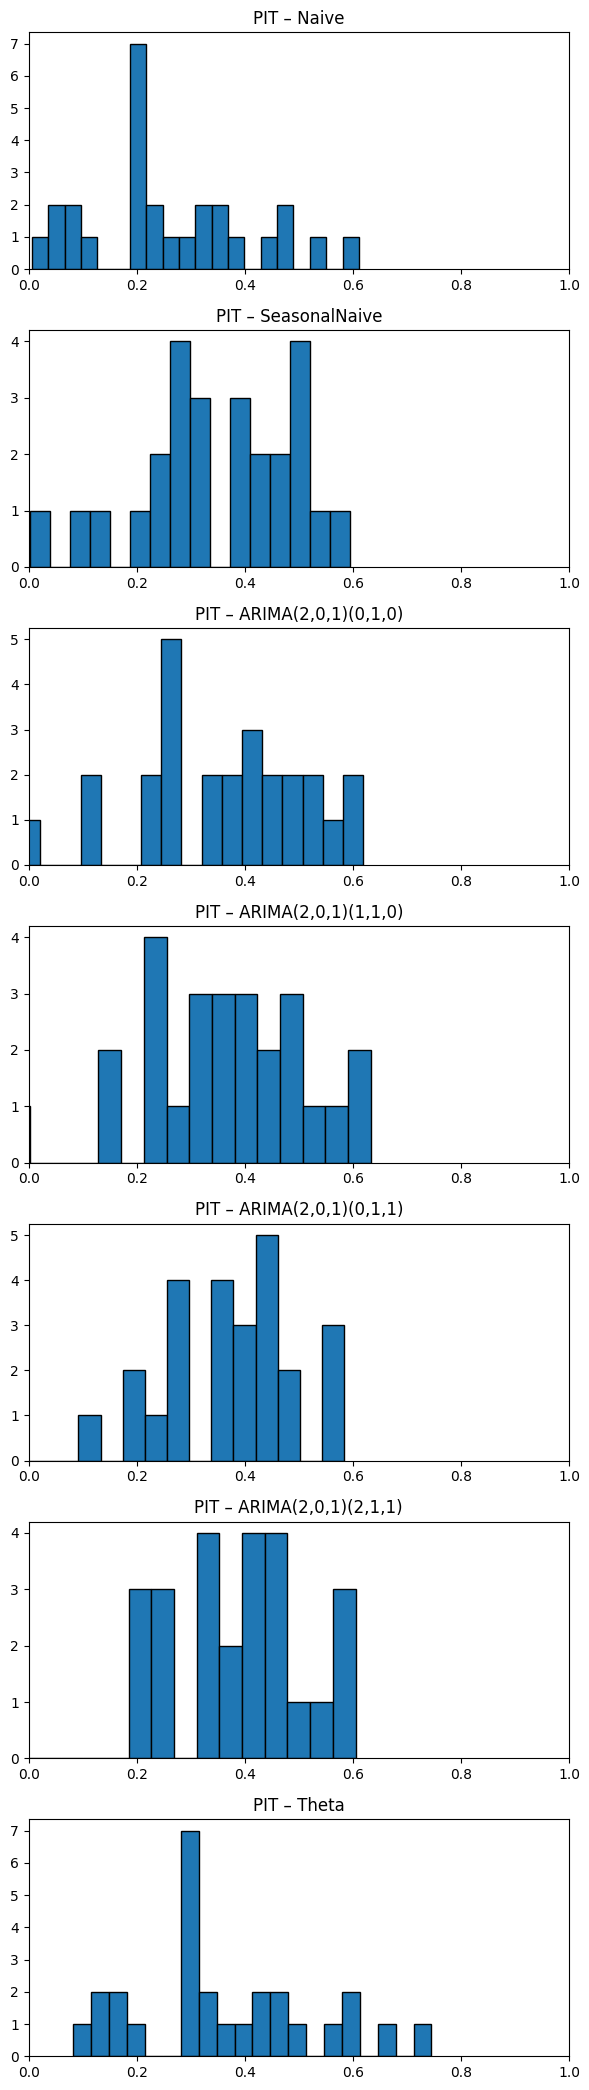

In [139]:
# 7.2 PIT histograms -------------------------------------------------------
fig, axes = plt.subplots(len(results), 1, figsize=(6, 3 * len(results)))
for ax, (mdl, d) in zip(axes, results.items()):
    resid = d["resid"]
    q_alpha = np.quantile(np.abs(resid), 1 - 0.10)
    u = 0.5 + np.sign(test_y.values - d["point"]) * 0.5 * (np.abs(test_y.values - d["point"]) / q_alpha)
    ax.hist(u, bins=20, edgecolor="black")
    ax.set_title(f"PIT – {mdl}")
    ax.set_xlim(0, 1)
fig.tight_layout()
plt.show()

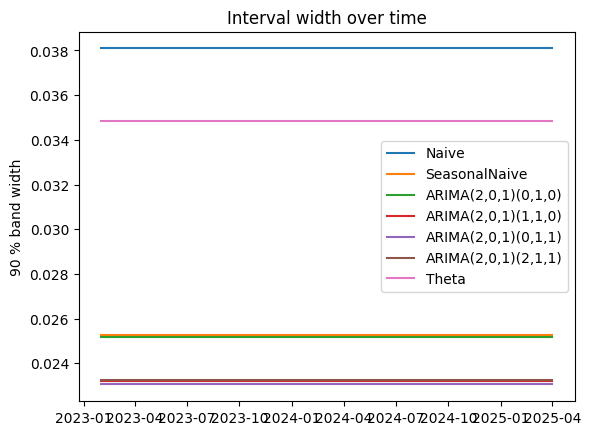

In [140]:
# 7.3 Interval‑width over time -------------------------------------------
fig, ax = plt.subplots()
for mdl, d in results.items():
    width = d["hi"]["_90"] - d["lo"]["_90"]
    ax.plot(test_df["ds"], width, label=mdl)
ax.set(ylabel="90 % band width", title="Interval width over time")
ax.legend()
plt.show()

## 7. Vizualisation of the best model predictions

In [146]:
best_model = 'ARIMA(2,0,1)(2,1,1)'          # change here if you choose another
point = results[best_model]['point']  # NumPy array
lo_90 = results[best_model]['lo']['_90']
hi_90 = results[best_model]['hi']['_90']

plot_df = pd.DataFrame({
    'actual': pd.concat([train_df['y'], cal_df['y'], test_df['y']]).values,
    'point' : pd.Series(point, index=test_df['ds']).reindex(test_df['ds']),
    'lo_90' : pd.Series(lo_90, index=test_df['ds']),
    'hi_90' : pd.Series(hi_90, index=test_df['ds']),
}, index=pd.concat([train_df['ds'], cal_df['ds'], test_df['ds']]))

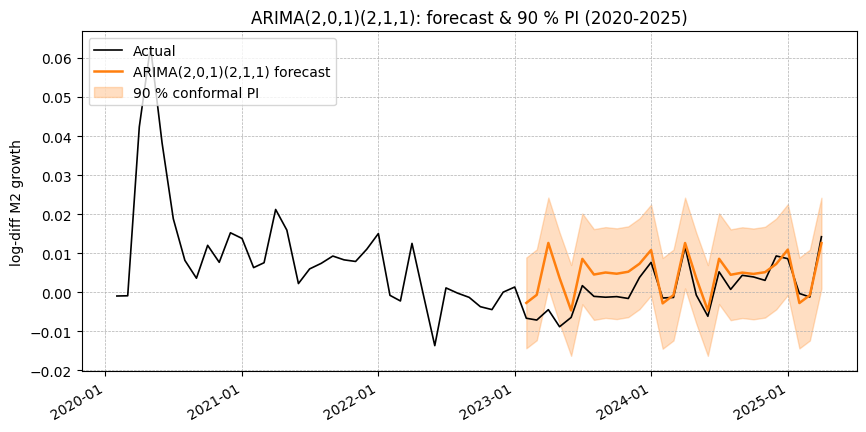

In [147]:
zoom = plot_df.loc['2020-01':'2025-12']

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(zoom.index, zoom['actual'], label='Actual', lw=1.2, color='black')
ax.plot(zoom.index, zoom['point'], label=f'{best_model} forecast',
        lw=1.8, color='tab:orange')
ax.fill_between(
    zoom.index, zoom['lo_90'], zoom['hi_90'],
    color='tab:orange', alpha=0.25, label='90 % conformal PI'
)

ax.set_title(f'{best_model}: forecast & 90 % PI (2020-2025)')
ax.set_ylabel('log-diff M2 growth')
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', linewidth=0.5)
fig.autofmt_xdate()

plt.show()

## 8. Additional diagnostics

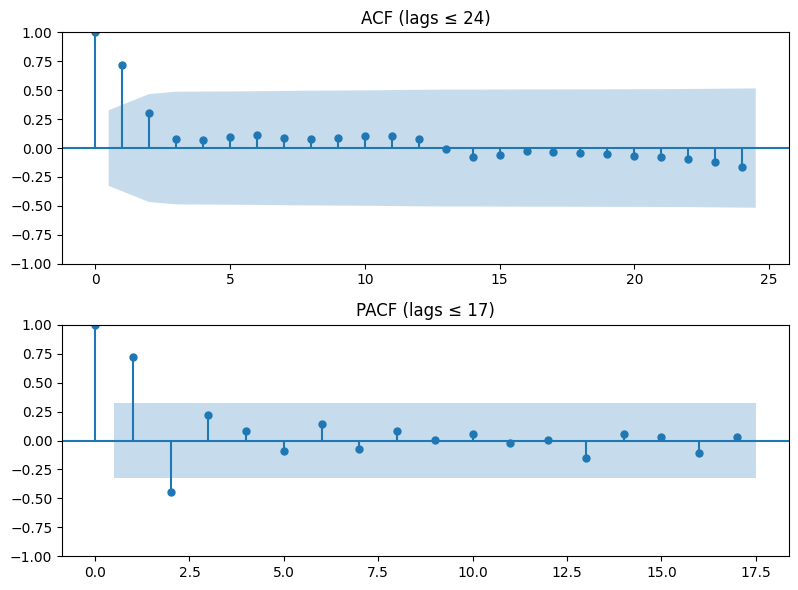

In [148]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from scipy import stats

resid = results['ARIMA(2,0,1)(2,1,1)']['resid']
max_acf_lags  = min(24, len(resid) - 1)             # ≤ n-1
max_pacf_lags = min(max_acf_lags, len(resid)//2 - 1)  # ≤ n/2 - 1

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(resid,  lags=max_acf_lags,  ax=ax[0])
plot_pacf(resid, lags=max_pacf_lags, ax=ax[1])

ax[0].set_title(f'ACF (lags ≤ {max_acf_lags})')
ax[1].set_title(f'PACF (lags ≤ {max_pacf_lags})')
plt.tight_layout()
plt.show()

In [149]:
# 2. Ljung–Box up to 36 lags
n_obs = len(resid)

# choose the lags you want, then filter
lags_requested = [12, 24, 36]
lags_ok = [lag for lag in lags_requested if lag < n_obs]   # keeps 12 and 24
print(lags_ok)

print(acorr_ljungbox(resid, lags=lags_ok, return_df=True))

[12, 24]
      lb_stat  lb_pvalue
12  28.023745   0.005488
24  35.672752   0.059029


In [150]:
# 3. ARCH test
arch_p = het_arch(resid)[1]
print(f'Engle ARCH p-value: {arch_p:0.4f}')

Engle ARCH p-value: 0.4417


In [151]:

# 4. Winkler interval score (90 % example)
alpha = 0.10
lo = results['SeasonalNaive']['lo']['_90']
hi = results['SeasonalNaive']['hi']['_90']
y  = test_y.values
winkler = (hi - lo) + (2/alpha)*(lo - y)*(y < lo) + (2/alpha)*(y - hi)*(y > hi)
print('Avg 90 % Winkler score:', winkler.mean())

Avg 90 % Winkler score: 0.02798135780147992
